# Ptychography Reconstruction

This notebook demonstrates a simulated ptychographic reconstruction using tike.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import tike
import tike.ptycho
import tike.view

In [2]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.15.2.dev39+g7ca618d.d20210126
numpy is version 1.19.5


## Load test data
This data was simulated using tike and it used for continuous integration testing.

In [3]:
import lzma
import pickle

with lzma.open('../../../tests/data/ptycho_setup.pickle.lzma', 'rb') as file:
    [
        data,
        scan,
        probe,
        original,
    ] = pickle.load(file)

### Define the object
The object consists of two unique views of varying phase: one with constant amplitude and one with varying amplitude.

In [4]:
original.shape

(2, 128, 128)

(-0.9999991+0.001338858j) (0.9940698+0.108743966j)


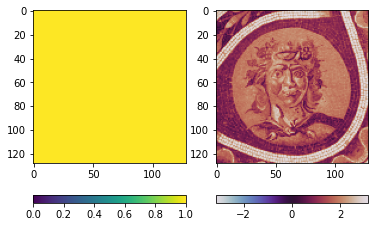

(-0.9617499+0.057536483j) (0.9270641+0.10761326j)


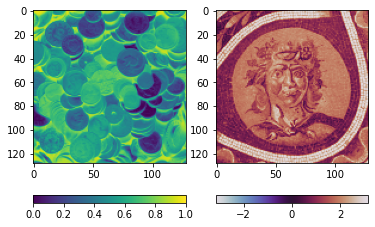

In [5]:
for i in range(len(original)):
    plt.figure()
    tike.view.plot_phase(original[i], amax=1, amin=0)
    plt.show()

### Define the probe

Note that the shape of the probe includes many dimensions. These dimensions are for providing multiple probes and eigen probes. Read the documentation of the `tike.ptycho.probe` module for more information.

In [6]:
probe *= 8

In [7]:
probe.shape

(2, 1, 1, 2, 16, 16)

/home/dching/Documents/tike/src/tike/view.py:95: UserWarning: This phase plot will be incorrect because the phase of a zero-amplitude complex number is undefined. Adding a small constant to the amplitude may help.
  "This phase plot will be incorrect because "


(-5.0351405+6.2167j) (7.9999995+0.002513274j)


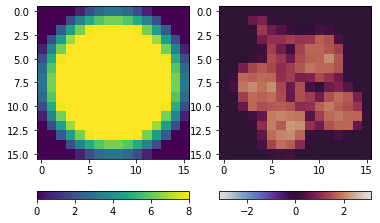

(-3.953918+0.60542j) (3.9883525+0.30503207j)


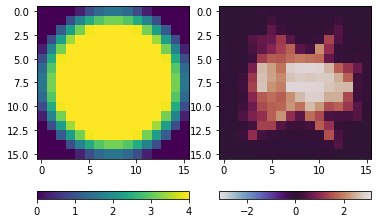

In [8]:
for m in range(probe.shape[-3]):
    plt.figure()
    tike.view.plot_phase(probe[0, 0, 0, m])
    plt.show()

Information about a probe which varies with each scanning position is stored in the `weights` and `coherent_probe` arrays.

In [9]:
# Add some probe variance
np.random.seed(0)
weights = tike.ptycho.probe.simulate_varying_weights(scan, probe)
varying_probe = tike.ptycho.probe.get_varying_probe(probe, eigen_probe=probe, weights=weights)

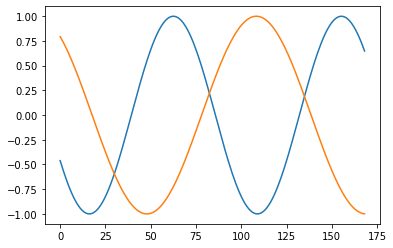

In [10]:
plt.figure()
plt.plot(weights[0, :, 0, 0])
plt.plot(weights[0, :, 0, 1])

### Define the trajectory

Each view may have a different trajectory, but the number of scan positions must be the same. The probe positions that overlap the edge of psi are not allowed.

In [11]:
scan.shape

(2, 169, 2)

In [12]:
# Add some position noise
np.random.seed(0)
true_scan = scan + 1 * (2 * np.random.rand(*scan.shape) - 1)

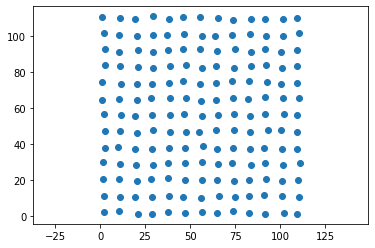

In [13]:
plt.figure()
plt.scatter(true_scan[0, :, 0], true_scan[0, :, 1])
plt.axis('equal')
plt.show()

## Simulate data acquisition

In [14]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(detector_shape=probe.shape[-1] * 2,
                            probe=varying_probe, scan=true_scan,
                            psi=original)
data.shape

(2, 169, 32, 32)

In [15]:
np.random.seed(0)
data = np.random.poisson(data)

/home/dching/miniconda3/envs/tike/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


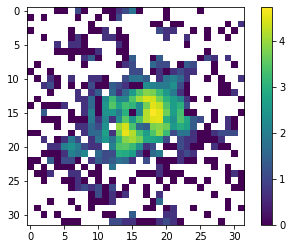

(0, 3958)

In [16]:
plt.figure()
plt.imshow(np.fft.fftshift(np.log(data[0, 11])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

## Reconstruct

Now we need to try and reconstruct psi.

In [17]:
eigen_probe, weights = tike.ptycho.probe.init_varying_probe(scan, probe, 1)

In [18]:
eigen_probe.shape, weights.shape

((2, 1, 1, 2, 16, 16), (2, 169, 1, 2))

In [19]:
# Provide initial guesses for parameters that are updated
result = {
    'psi': np.ones(original.shape, dtype='complex64'),
    'probe': probe,
    'scan': scan,
    'eigen_probe': eigen_probe,
    'eigen_weights': weights,
}
cost = np.array([])


In [20]:
logging.basicConfig(level=logging.INFO)

for i in range(4):
    result = tike.ptycho.reconstruct(
        data=data,
        **result,
        algorithm='lstsq_grad',
        num_iter=32,
        recover_probe=True,
    )

    cost = np.concatenate((cost, result['cost']))

INFO:tike.ptycho.ptycho:lstsq_grad for 169 - 32 by 32 frames for 32 iterations.
INFO:tike.ptycho.ptycho:Split data into 1 mini-batches.
INFO:tike.ptycho.ptycho:object and probe rescaled by 0.952840
INFO:tike.ptycho.ptycho:lstsq_grad epoch 0
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.44752e+06
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.61879e+05
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.00647e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.88977e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.83071e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.32868e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 1
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.45564e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.11391e+05
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.61865e+02
INFO:tike.ptych

INFO:tike.ptycho.solvers.divided: nearplane cost is +1.11136e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.06923e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 15
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.11527e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +7.78817e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.86966e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.61955e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.10176e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.08029e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 16
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.07539e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +7.68847e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.85252e+02
INFO:tike.ptycho.solver

INFO:tike.ptycho.solvers.divided: nearplane cost is +1.01623e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.31337e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 30
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.70281e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.75702e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.67650e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.72816e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.01185e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.33354e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 31
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.68383e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.70958e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.66697e+02
INFO:tike.ptycho.solver

INFO:tike.ptycho.solvers.divided: nearplane cost is +1.56372e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.91965e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.59216e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.62814e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 13
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.46657e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.16643e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.55701e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.93710e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.55708e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.65132e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 14
INFO:tike.ptycho.solvers.divid

INFO:tike.ptycho.solvers.divided: nearplane cost is +1.46807e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.20937e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.09811e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.97941e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 28
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.28023e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.70059e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.46199e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.23056e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.06773e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.00300e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 29
INFO:tike.ptycho.solvers.divid

INFO:tike.ptycho.solvers.divided: nearplane cost is +2.28277e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 10
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.12772e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.31929e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.38149e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.51630e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +8.65897e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.30743e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 11
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.11759e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +5.29398e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.37608e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.54044e+02
INFO:tike.ptycho.solver

INFO:tike.ptycho.solvers.divided: nearplane cost is +2.63231e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 25
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.98335e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.95837e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.30338e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.86531e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +8.25111e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.65433e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 26
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.97436e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.93591e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.29845e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.88785e+02
INFO:tike.ptycho.solver

INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.10916e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.90492e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.88779e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 8
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.86334e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.65836e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.23769e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.13439e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.88337e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.91160e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 9
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.85577e+05
INFO:tike.ptycho.solvers.divided

INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.42693e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.60198e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.20749e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 23
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.76399e+05
INFO:tike.ptycho.solvers.divided:  farplane cost is +4.40997e+04
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.18158e+02
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.44542e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.58284e+01
INFO:tike.ptycho.solvers.divided:Updating coherent probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +3.22682e+02
INFO:tike.ptycho.ptycho:lstsq_grad epoch 24
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.75811e+05
INFO:tike.ptycho.solvers.divid

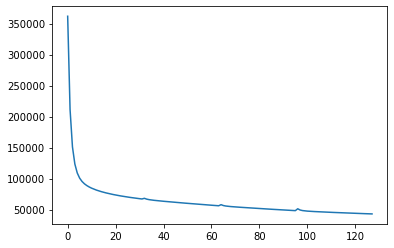

In [21]:
plt.figure()
plt.plot(cost)
plt.show()

(-1.7280259+0.3775705j) (3.2064404-0.07200402j)
(-3.8574307+6.786645j) (8.563951+1.944608j)
(-4.5991707+1.351527j) (4.504342+0.9333741j)


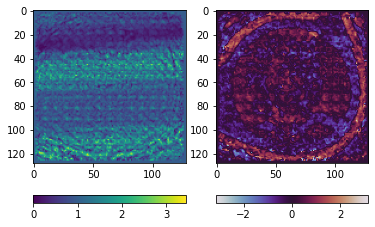

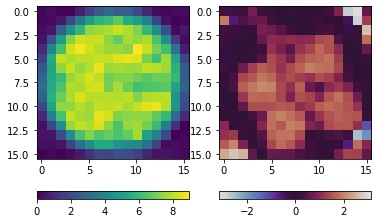

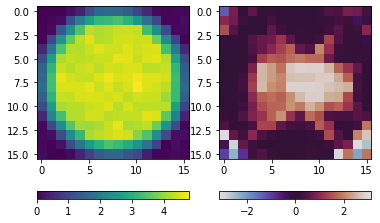

(-0.9815827+0.004684097j) (2.8880303-0.14989793j)
(-4.714744+6.104272j) (7.863942-0.03401426j)
(-4.1679273+0.7099677j) (4.231762+0.35558715j)


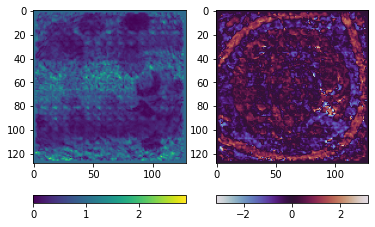

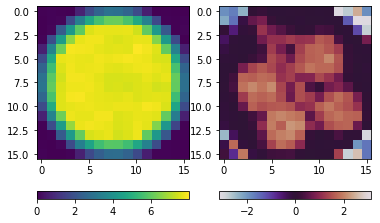

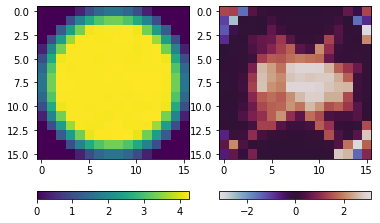

In [22]:
for v in range(len(original)):
    plt.figure()
    tike.view.plot_phase(result['psi'][v], amin=0)
    for m in range(probe.shape[-3]):
        plt.figure()
        tike.view.plot_phase(result['probe'][v, 0, 0, m], amin=0)
    plt.show()